# Import Libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
import nltk
import joblib

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Data Loading and Overview

In [ ]:
df = pd.read_csv('/content/spam.csv',encoding = 'latin-1')

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.shape

(5572, 5)

# Data Cleaning

In [ ]:
df = df.drop(labels=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.columns = ["label", "message"]

In [ ]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.duplicated().sum()

403

In [ ]:
df = df.drop_duplicates(keep='first')

# Data Visualization

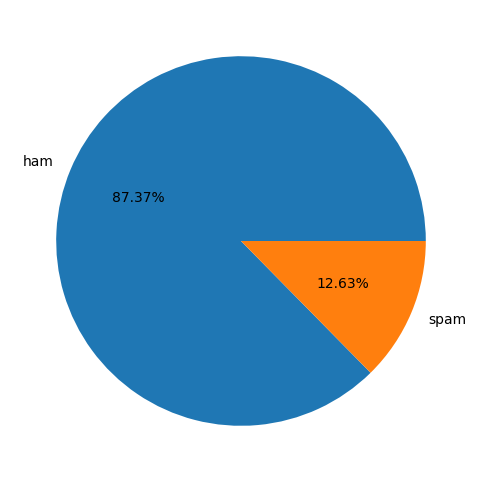

In [ ]:
plt.figure(figsize=(6,6))

x = df.label.value_counts()
labels = ['ham', 'spam']
plt.pie(x, labels=labels, autopct='%0.2f%%')
plt.show()

In [ ]:
df['length'] = df['message'].apply(len)
df.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


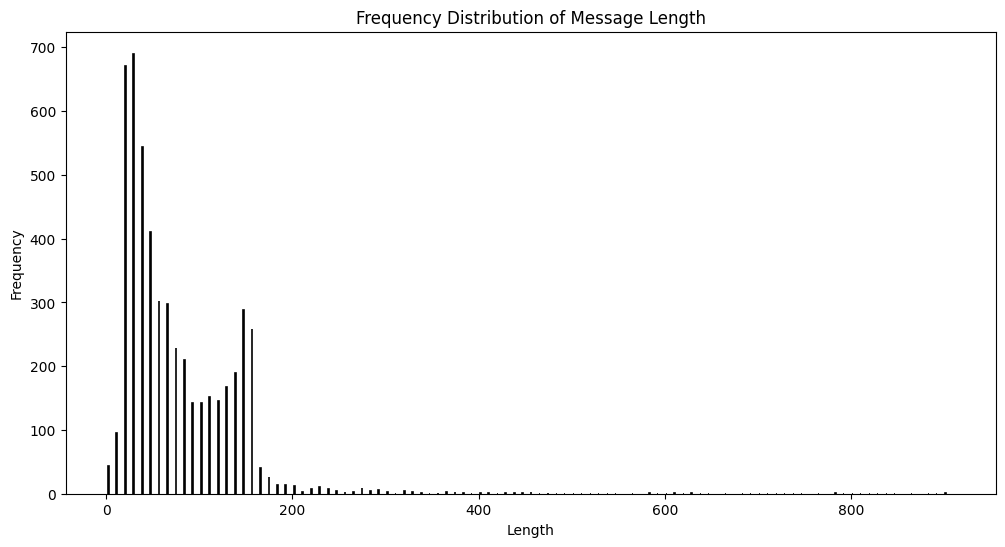

In [ ]:
plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(df['length'], bins=100, edgecolor='black', linewidth=1.2, width=0.9)
plt.title("Frequency Distribution of Message Length")
plt.xlabel("Length")
plt.ylabel("Frequency")

plt.show()


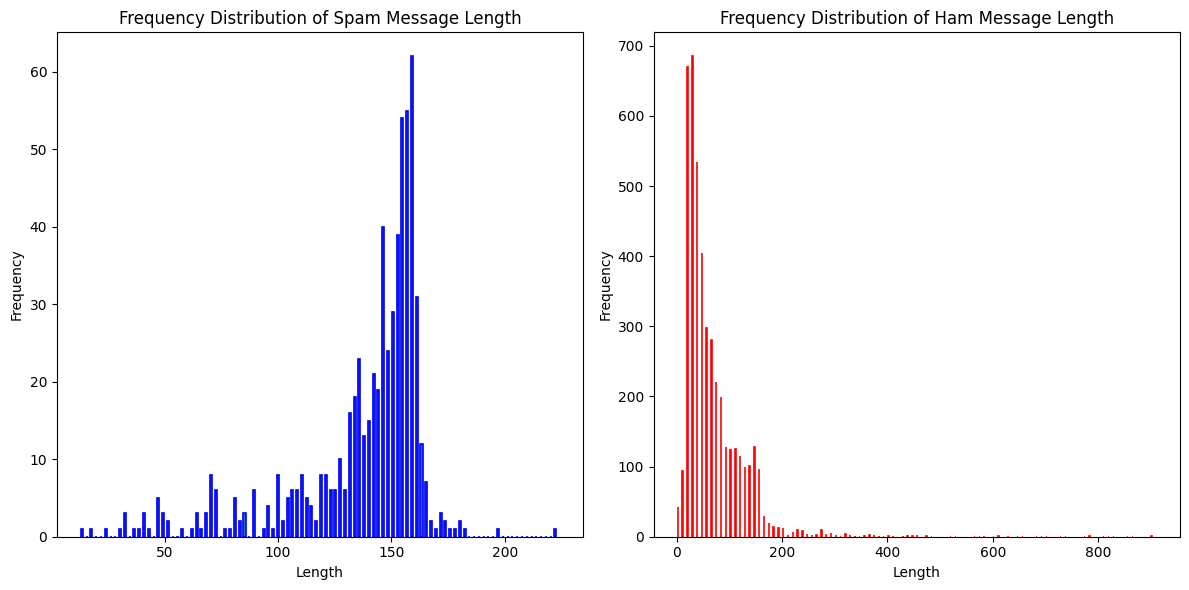

In [ ]:
spam_lengths = df[df['label'] == 'spam']['length']
ham_lengths = df[df['label'] == 'ham']['length']

plt.figure(figsize=(12, 6))

# histogram for spam messages
plt.subplot(1, 2, 1)
n, bins, patches = plt.hist(spam_lengths, bins=100, edgecolor='blue', linewidth=1.2, width=0.9)
plt.title("Frequency Distribution of Spam Message Length")
plt.xlabel("Length")
plt.ylabel("Frequency")

# histogram for ham messages
plt.subplot(1, 2, 2)
n, bins, patches = plt.hist(ham_lengths, bins=100, edgecolor='red', linewidth=1.2, width=0.9)
plt.title("Frequency Distribution of Ham Message Length")
plt.xlabel("Length")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Preprocessing

In [ ]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^0-9a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    stop_words = set(stopwords.words('english'))
    text = " ".join(word for word in text.split() if word not in stop_words)
    lemmatizer = WordNetLemmatizer()
    text = " ".join(lemmatizer.lemmatize(word) for word in text.split())
    return text

df['clean_text'] = df['message'].apply(clean_text)

# Creating Model

In [ ]:
# Split data into training and test sets
msg_train, msg_test, label_train, label_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

# Define the text processing function
def message_text_process(mess):
    no_punctuation = [char for char in mess if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return [word for word in no_punctuation.split() if word.lower() not in stopwords.words('english')]

In [ ]:

pipeline = Pipeline([
    ('vectorizer', CountVectorizer(analyzer=message_text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'classifier__alpha': [0.1, 0.5, 1.0]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Fit the model
grid_search.fit(msg_train, label_train)

# Best parameters and evaluation
print("Best parameters: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

Best parameters:  {'classifier__alpha': 0.1}


In [ ]:
# Evaluate the best model
predictions = best_model.predict(msg_test)
print(metrics.classification_report(label_test, predictions))
print(metrics.confusion_matrix(label_test, predictions))
print("Accuracy of Test dataset: {0:0.3f}".format(metrics.accuracy_score(label_test, predictions)))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       889
        spam       0.98      0.88      0.93       145

    accuracy                           0.98      1034
   macro avg       0.98      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034

[[887   2]
 [ 17 128]]
Accuracy of Test dataset: 0.982


In [ ]:
# Save the model
joblib.dump(best_model, 'spam_classifier_pipeline.pkl')

# Load the model
loaded_model = joblib.load('spam_classifier_pipeline.pkl')


# Using Model

In [ ]:
# classify new messages
def classify_message(message):
    clean_message = clean_text(message)
    prediction = loaded_model.predict([clean_message])
    return prediction[0]


new_message = "Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/123456 to claim now."
print("New message classification: ", classify_message(new_message))


New message classification:  spam


In [ ]:
new_message2 = "Hi! I am waiting for you at the cafe."
print ("New message classification: ", classify_message(new_message2))

New message classification:  ham


In [ ]:
new_message3 = "ACTION REQUIRED. Please verify your Bank of America account information to avoid a hold on your account. Click here to confirm: ."
print ("New message classification: ", classify_message(new_message3))

New message classification:  spam


In [ ]:
new_message4 = "Congratulations! Your credit score entitles you to a no-interest Visa credit card. Click here to claim:."
print ("New message classification: ", classify_message(new_message4))

New message classification:  spam


In [ ]:
new_message6 = "We’re happy to inform you that you’re entitled to a refund for overpayment on your AMEX account. Click on this link [Link] below to claim your refund:."
print ("New message classification: ", classify_message(new_message6))

New message classification:  spam


In [ ]:
new_message5 = "Hi Grandpa, it’s me – I’ve been in a car accident, and my parents aren’t around. Can you please send me money so I can get home? You can wire funds to me here: ."
print ("New message classification: ", classify_message(new_message5))

New message classification:  ham


In [ ]:
new_message7 = " ACTION REQUIRED. Please verify your Bank of America account information to avoid a hold on your account. Click here to confirm: [Link]"
print ("New message classification: ", classify_message(new_message7))

New message classification:  spam


In [ ]:
new_message8 = "You’ve been overcharged for your 2021 taxes. Get your IRS tax refund here: [Link]"
print ("New message classification: ", classify_message(new_message8))

New message classification:  ham


In [ ]:
new_message9 = "Get delivery updates on your USPS order [Number] here: [Link] "
print ("New message classification: ", classify_message(new_message9))

New message classification:  spam


In [ ]:
new_message10 = "Thank you for paying last month’s bill. We’re rewarding our very best customers with a gift for their loyalty. Click here! [Link] "
print ("New message classification: ", classify_message(new_message10))

New message classification:  ham


In [ ]:
new_message11 = "We’ve received your resume and would love to set up an online interview. Click here [Link] or call us at [Phone Number] at your earliest convenience.[Link] "
print ("New message classification: ", classify_message(new_message11))

New message classification:  ham


In [ ]:
new_message12 = "There’s an issue with your payment information from your recent order [Order Number]. Take action now: [Link]"
print ("New message classification: ", classify_message(new_message12))

New message classification:  spam


In [ ]:
new_message13 = "Congratulations! You have all been selected to receive a free gift card worth $1000. Click on this link [Link] to claim your reward now. Limited time offer, so act fast! Don't miss out on this amazing opportunity.."
print ("New message classification: ", classify_message(new_message13))

New message classification:  spam
